# Land Use Optimization

- There is a set of urban blocks in a relatively small area. 
- The task is to to determine the optimal layout of functional zones. 
- Also it is necessary to identify the possible optimal composition of services for this area.

## Optimizing land uses

Load blocks spatial data and visualize it.

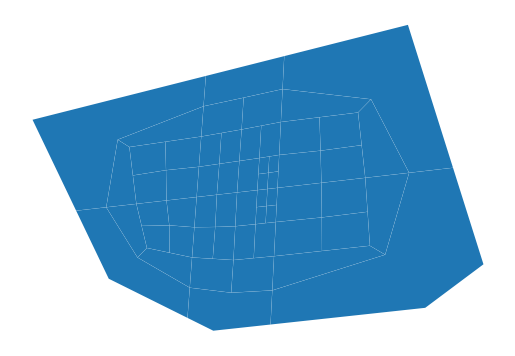

In [1]:
import geopandas as gpd

blocks_gdf = gpd.read_file('../blocks.geojson')[['geometry']]
blocks_gdf.geometry = blocks_gdf.buffer(-0.5)
blocks_gdf = gpd.GeoDataFrame(blocks_gdf.geometry.explode(True)).reset_index(drop=True)
blocks_gdf.plot().set_axis_off()

Initializing `LandUseOptimizer` instance. After initializing the loaded blocks will also be cut to fit possible aspect ratios. 

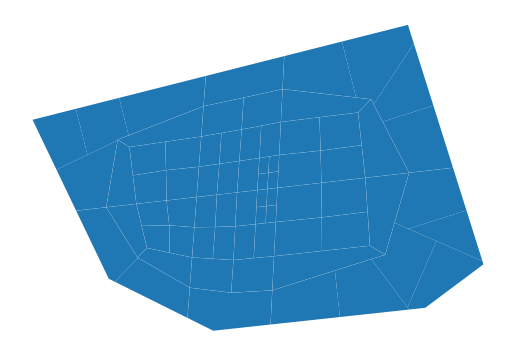

In [2]:
from blocksnet.preprocessing import LandUseOptimizer

luo = LandUseOptimizer(blocks_gdf)
luo.blocks.plot().set_axis_off()

Determine desired **Land Use** shares. The optimizer will try to fit these shares using MSE.

In [3]:
from blocksnet import LandUse

lu_shares = {
  LandUse.RESIDENTIAL: 0.3,
  LandUse.BUSINESS: 0.2,
  LandUse.RECREATION: 0.2,
  LandUse.SPECIAL: 0.05,
  LandUse.INDUSTRIAL: 0.05,
  LandUse.AGRICULTURE: 0.1,
  LandUse.TRANSPORT: 0.1
}

Run `LandUseOptimizer` instance calculation method `run()`. It will return the following result:
- `best_X` - best variables found in the simulated annealing process.
- `best_value` - best fit value (the smaller it is, the closer optimization was to the desired shares).
- `Xs` - list of X during all the iterations.
- `values` - list of fit values during all the iterations.

The optimizer will try to fit desired shares according to rules:
- Some land uses can't be adjacent to others (like residential and industrial).
- Some land uses have max ratio possible. For example, residential blocks will vary from 1:1 to 1:3.

In [4]:
best_X, best_value, Xs, values = luo.run(lu_shares, rate=0.999, max_iter=100_000)

Value : 0.004:  20%|██        | 20255/100000 [02:11<08:38, 153.88it/s]


After the method found some result, we can visualize the flow of fit value to see how it changed.

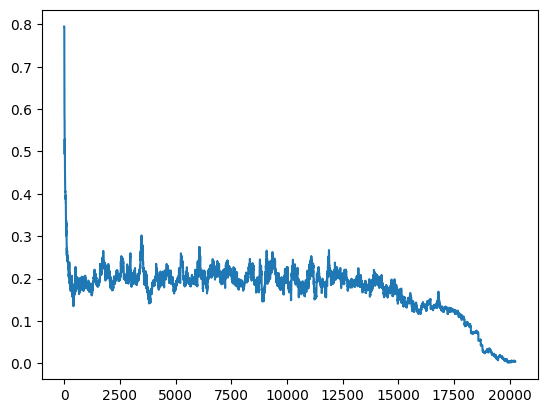

In [5]:
import matplotlib.pyplot as plt

plt.plot(values)

As we can see, it successfully found some kind of value close to `0.0`. Otherwise we could adjust rate, temperature, or iterations of the optimizer.

In [6]:
best_value

0.001998457049778621

In [7]:
luo.to_shares_dict(best_X)

{<LandUse.RESIDENTIAL: 'residential'>: 0.26136152081823005,
 <LandUse.BUSINESS: 'business'>: 0.2084201382217867,
 <LandUse.RECREATION: 'recreation'>: 0.19428657048692446,
 <LandUse.SPECIAL: 'special'>: 0.055519879096642556,
 <LandUse.INDUSTRIAL: 'industrial'>: 0.06251407231282412,
 <LandUse.AGRICULTURE: 'agriculture'>: 0.10371699128343877,
 <LandUse.TRANSPORT: 'transport'>: 0.11418082778015352}

Let's see how proportions of desired Land Uses changed.

<Axes: >

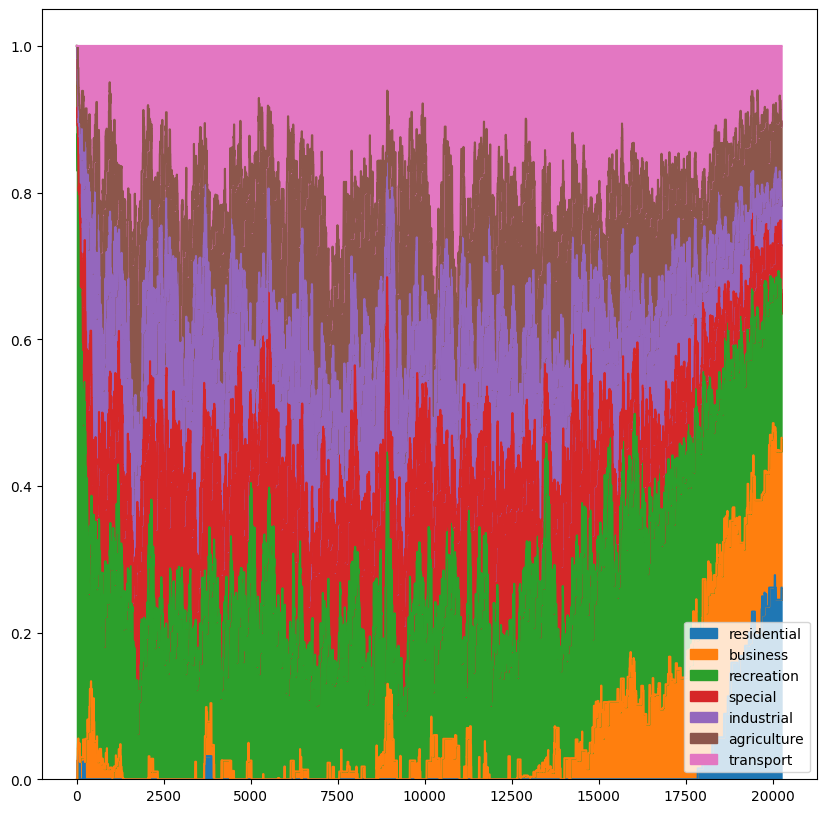

In [8]:
import pandas as pd

df = pd.DataFrame([{lu.value : share for lu,share in luo.to_shares_dict(X).items()} for X in Xs])
df.plot(kind='area', stacked=True, figsize=(10,10))

Finally, visualize the result. As we can see, residential blocks mostly locate at the periphery.

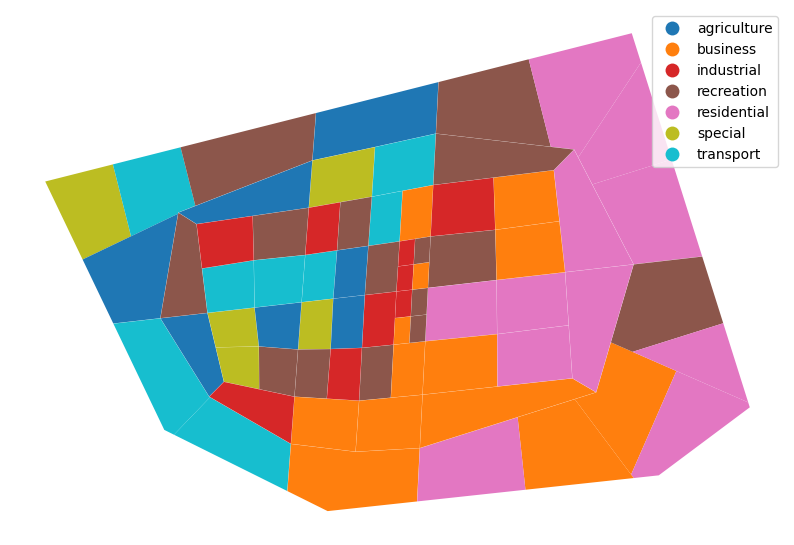

In [9]:
luo.to_gdf(best_X).plot(column='land_use', legend=True, figsize=(10,10)).set_axis_off()

## Services optimizer

We have to find optimal services composition for this land use set.

In [10]:
import networkx as nx
from blocksnet import AccessibilityProcessor
from shapely import length, LineString, Point

SPEED = 10 * 1000 / 60

graph = luo.adjacency_graph.copy()
graph.graph['crs'] = luo.blocks.crs.to_epsg()
for node, data in graph.nodes(data=True):
  point = luo.blocks.loc[node,'geometry'].representative_point()
  data['geometry'] = point
  data['x'] = point.x
  data['y'] = point.y
for u, v, data in graph.edges(data=True):
  point_u = graph.nodes[u]['geometry']
  point_v = graph.nodes[v]['geometry']
  line_string = LineString([point_u, point_v])
  data['time_min'] = length(line_string)/SPEED

ap = AccessibilityProcessor(luo.blocks)
acc_mx = ap.get_accessibility_matrix(graph)

In [11]:
from blocksnet import City

city = City(luo.to_gdf(best_X), acc_mx)

Value : 0.431:   1%|          | 599/100000 [00:51<2:21:11, 11.73it/s]


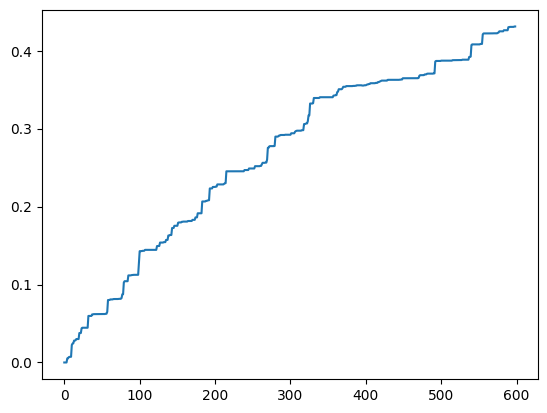

In [15]:
from blocksnet.method.annealing_optimizer import AnnealingOptimizer, LU_FSIS, LU_GSIS

blocks_lu = {block.id : best_X[block.id] for block in city.blocks}
blocks_fsi = {b_id : LU_FSIS[lu][0] for b_id, lu in blocks_lu.items()}
blocks_gsi = {b_id : LU_GSIS[lu][0] for b_id, lu in blocks_lu.items()}
service_types = {service_type.name : 1/len(city.service_types) for service_type in city.service_types}

values = []

def on_iteration(i, X, indicators, value):
    values.append(value)

ao = AnnealingOptimizer(city_model=city, on_iteration=on_iteration, verbose=True)
X, indicators, value, provisions = ao.calculate(blocks_lu, blocks_fsi, blocks_gsi, service_types, rate=0.95, max_iter=100_000)

plt.plot(values)

In [17]:
provisions

{'school': 0.3019165135206091,
 'kindergarten': 0.1721170395869191,
 'hospital': 1.0,
 'polyclinic': 0.5546623794212219,
 'pitch': 0.23357664233576642,
 'swimming_pool': 0.7822685788787483,
 'stadium': 1.0,
 'theatre': 1.0,
 'museum': 1.0,
 'cinema': 1.0,
 'mall': 1.0,
 'convenience': 0.03501196242049367,
 'supermarket': 0.011672970070504739,
 'cemetery': 0.0,
 'religion': 1.0,
 'market': 0.35456336178594877,
 'bowling_alley': 1.0,
 'university': 0.8038585209003215,
 'playground': 0.22448979591836735,
 'pharmacy': 0.17445917655268667,
 'fuel': 0.03177629488401652,
 'beach': 0.1639881928501148,
 'train_building': 1.0,
 'bank': 0.5238344683080147,
 'lawyer': 1.0,
 'cafe': 0.20553691275167785,
 'subway_entrance': 0.9333916939159093,
 'multifunctional_center': 0.014418496871701126,
 'hairdresser': 0.2502606882168926,
 'restaurant': 0.16853932584269662,
 'bar': 0.13003355704697986,
 'park': 0.0,
 'government': 1.0,
 'recruitment': 0.6420097697138869,
 'hotel': 0.0,
 'zoo': 1.0,
 'circus': 1

This set of service units if the first approximation of possible composition.

In [16]:
ao.to_bricks_df(X)

,block_id,service_type,is_integrated,area,capacity,count
89,1,train_station,False,1300.0,100,1
1259,19,bus_station,False,320.0,200,1
1271,19,hostel,True,100.0,20,1
1283,19,sanatorium,True,4000.0,1000,1
1317,19,substation,False,35000.0,70,1
...,...,...,...,...,...,...
8737,82,pharmacy,False,85.0,70,1
8769,82,stadium,False,35000.0,21000,1
8792,82,restaurant,True,800.0,200,1
8819,82,train_station,False,1300.0,100,1
